In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import os
import numpy as np
from sklearn.model_selection import train_test_split

from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, CSVLogger

In [9]:
os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
dataDir = ('./datasets/TOP-VIEW HEADS DATASET')

images = np.load(os.path.join(dataDir, 'images(8 Bit).npy'))

# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load(os.path.join(dataDir, 'masks.npy'))
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))

Images: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 0.5567962527275085 | Min-Val: -3.5179946422576904
Masks: (1815, 96, 128, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (1452, 96, 128, 1) | Train Masks: (1452, 96, 128, 1)
Validation Images: (363, 96, 128, 1) | Validation Masks: (363, 96, 128, 1)


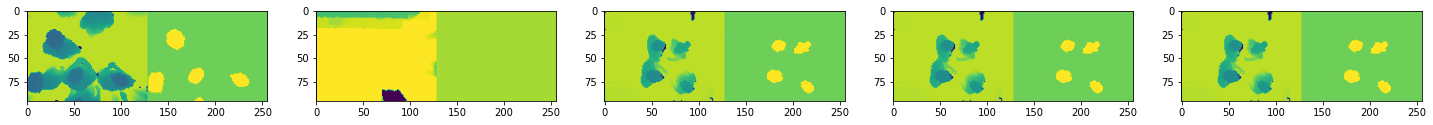

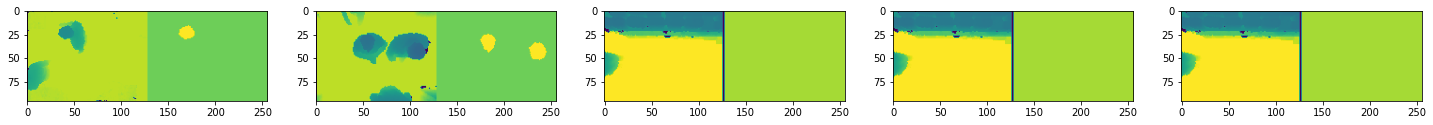

In [10]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [11]:

img_rows = 96
img_cols = 128
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    up_conv_name_base = 'up' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet_Architecture(filters=16, bn_axis=3, classes=1):
    inputs = Input((img_rows, img_cols, 1))
    x = ZeroPadding2D((4, 4))(inputs)
    x = Conv2D(filters, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [filters, filters, filters * 2], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [filters, filters, filters * 2], stage=2, block='b')
    x2 = identity_block(x, 3, [filters, filters, filters * 2], stage=2, block='c')

    x = conv_block(x2, 3, [filters * 2, filters * 2, filters * 4], stage=3, block='a')
    x = identity_block(x, 3, [filters * 2, filters * 2, filters * 4], stage=3, block='b')
    x3 = identity_block(x, 3, [filters * 2, filters * 2, filters * 4], stage=3, block='d')

    x = conv_block(x3, 3, [filters * 4, filters * 4, filters * 8], stage=4, block='a')
    x = identity_block(x, 3, [filters * 4, filters * 4, filters * 8], stage=4, block='b')
    x4 = identity_block(x, 3, [filters * 4, filters * 4, filters * 8], stage=4, block='f')

    x = conv_block(x4, 3, [filters * 8, filters * 8, filters * 16], stage=5, block='a')
    x = identity_block(x, 3, [filters * 8, filters * 8, filters * 16], stage=5, block='b')
    x = identity_block(x, 3, [filters * 8, filters * 8, filters * 16], stage=5, block='c')

    x = up_conv_block(x, 3, [filters * 16, filters * 8, filters * 8], stage=6, block='a')
    x = identity_block(x, 3, [filters * 16, filters * 8, filters * 8], stage=6, block='b')
    x = identity_block(x, 3, [filters * 16, filters * 8, filters * 8], stage=6, block='c')

    x = concatenate([x, x4], axis=bn_axis)

    x = up_conv_block(x, 3, [filters * 16, filters * 4, filters * 4], stage=7, block='a')
    x = identity_block(x, 3, [filters * 16, filters * 4, filters * 4], stage=7, block='b')

    x = identity_block(x, 3, [filters * 16, filters * 4, filters * 4], stage=7, block='f')

    x = concatenate([x, x3], axis=bn_axis)

    x = up_conv_block(x, 3, [filters * 8, filters * 2, filters * 2], stage=8, block='a')
    x = identity_block(x, 3, [filters * 8, filters * 2, filters * 2], stage=8, block='b')
    x = identity_block(x, 3, [filters * 8, filters * 2, filters * 2], stage=8, block='d')

    x = concatenate([x, x2], axis=bn_axis)

    x = up_conv_block(x, 3, [filters * 4, filters, filters], stage=10, block='a', strides=(1, 1))
    x = identity_block(x, 3, [filters * 4, filters, filters], stage=10, block='b')
    x = identity_block(x, 3, [filters * 4, filters, filters], stage=10, block='c')

    x = UpSampling2D(size=(2, 2))(x)
    outputs = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = ResNet_Architecture(filters=16, bn_axis=3, classes=1) 
model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy', precision, recall, f1score])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 128, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 104, 136, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 65, 16)   800         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 49, 65, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________

In [12]:
modelDir = './saved Models/ResNet Models/TOP VIEW HEADS'
if not os.path.exists(modelDir):
  os.makedirs(modelDir)
  print('Directory Created')
  
csv_logger = CSVLogger('./saved Models/ResNet Models/TOP VIEW HEADS/Training-Logs.csv')
checkpoint = ModelCheckpoint('./saved Models/ResNet Models/TOP VIEW HEADS/best-model.h5', verbose=1, monitor='val_acc',
                             save_best_only=True, mode='auto')  

model.fit(images_train, masks_train, batch_size=64, epochs=100, verbose=1, shuffle=True, validation_data = (images_test, masks_test),
          callbacks=[csv_logger, checkpoint])

Directory Created


Train on 1452 samples, validate on 363 samples
Epoch 1/100
1452/1452 [==============================] - 31s 21ms/step - loss: -0.1207 - dice_coef: 0.1207 - acc: 0.4205 - precision: 0.0689 - recall: 0.9813 - f1score: 0.1281 - val_loss: -0.1152 - val_dice_coef: 0.1152 - val_acc: 0.4063 - val_precision: 0.0646 - val_recall: 0.9986 - val_f1score: 0.1213

Epoch 00001: val_acc improved from -inf to 0.40632, saving model to ./saved Models/ResNet Models/TOP VIEW HEADS/best-model.h5
Epoch 2/100
1452/1452 [==============================] - 3s 2ms/step - loss: -0.2142 - dice_coef: 0.2142 - acc: 0.7523 - precision: 0.1383 - recall: 0.9566 - f1score: 0.2407 - val_loss: -0.1734 - val_dice_coef: 0.1734 - val_acc: 0.6687 - val_precision: 0.1097 - val_recall: 0.9940 - val_f1score: 0.1975

Epoch 00002: val_acc improved from 0.40632 to 0.66874, saving model to ./saved Models/ResNet Models/TOP VIEW HEADS/best-model.h5
Epoch 3/100
1452/1452 [==============================] - 3s 2ms/step

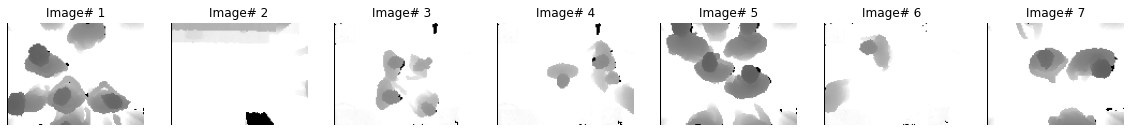

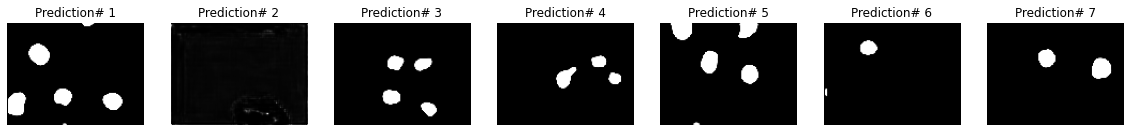

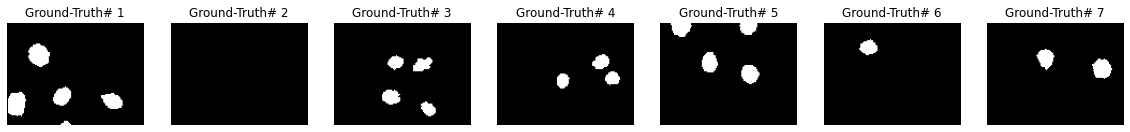

In [13]:
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

pred = model.predict(images_test)
plot_images(images_test, pred, masks_test)